In [1]:
from naqst import *
import time

In [2]:
path = "Data/examples/"
# files = os.listdir(path)
file_name = "square_root_7.qasm"
print(file_name)


square_root_7.qasm


In [3]:
total_time = time.time()
# circuit = CreateCircuitFromQASM(file_name, path)
circuit = QuantumCircuit.from_qasm_file(path+file_name)
#transform to cz-based circuit
cz_circuit = transpile(circuit, basis_gates=['cz', 'rx', 'ry', 'rz', 'h', 't'])
#cz gates list
gate_2q_list = get_2q_gates_list(cz_circuit)
#obtain corresponding DAG
_ , dag = gates_list_to_QC(gate_2q_list)

Num of gates 3089


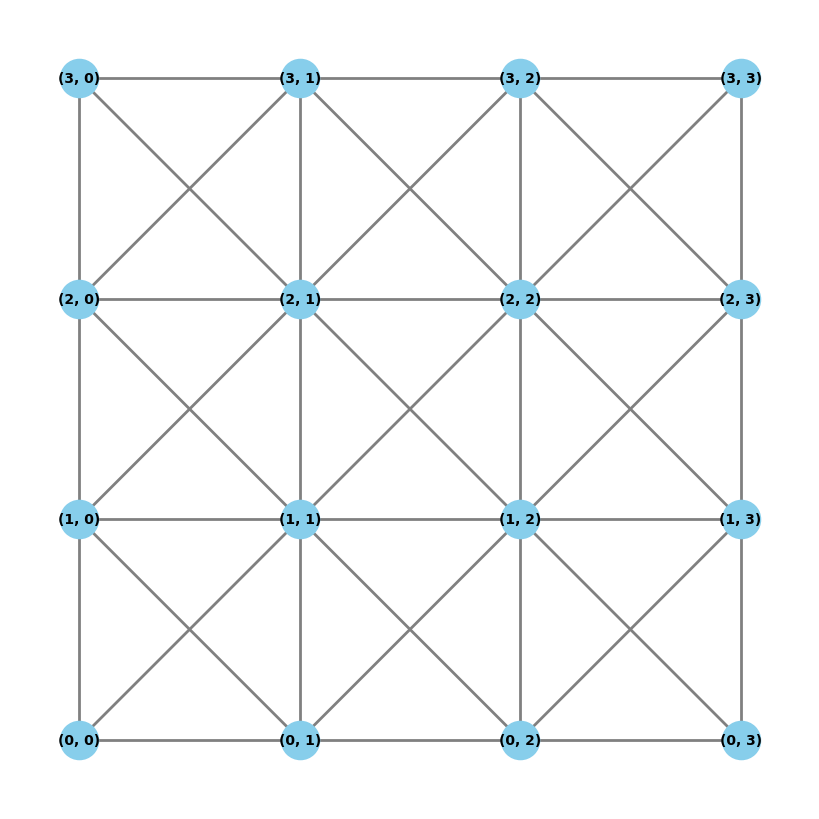

In [4]:
gate_num = len(gate_2q_list)
#obtain the qubits number
num_q = qubits_num(gate_2q_list)
print("Num of gates", gate_num)

arch_size = math.ceil(math.sqrt(num_q))
Rb = math.sqrt(2)
#obtain the corresponding coupling_graph 
coupling_graph = generate_grid_with_Rb(arch_size,arch_size, Rb)

import matplotlib.pyplot as plt
pos = {(x, y): (y, x) for x, y in coupling_graph.nodes()}

# Draw the graph with a customized style
plt.figure(figsize=(8, 8))
nx.draw(coupling_graph, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=700, font_size=10, font_color='black', font_weight='bold', linewidths=2, width=2)
plt.show()

In [5]:
def gate_in_layer(gate_list:list[list[int]])->list[map]:
    res = []
    for i in range(len(gate_list),-1):
        assert len(gate_list[i]) == 2
        res.append({'id':i,'q0':gate_list[i][0],'q1':gate_list[i][1]})
    return res

In [6]:
import time
#obtain the gates partition
time_part = time.time()
partition_gates = parition_from_DAG(dag, coupling_graph)
time_part1 = time.time()
print("partition time is, ",time_part1-time_part)
#ws.append(["partition time", time_part1-time_part])
#print("------------------------------")
part_gate_num = 0
for gates in partition_gates:
#		print("------")
    part_gate_num += len(gates)
#	print(gates)
print("final num is:", part_gate_num)


#for each partition, find a proper embedding
embeddings = []
tmp_graph = nx.Graph()
tmp_graph.add_edges_from(partition_gates[0])
initial_map = get_rx_one_mapping(tmp_graph, coupling_graph)
embeddings.append(map2list(initial_map,num_q))
print("partition number:", len(partition_gates))
for i in range(1, len(partition_gates)):
    data = []
    tmp_graph = nx.Graph()
    tmp_graph.add_edges_from(partition_gates[i])
    print(tmp_graph.edges())
    data.append(str(partition_gates[i]))
    time1 = time.time()
    next_embedding = get_rx_one_mapping(tmp_graph, coupling_graph)
    next_embedding = map2list(next_embedding,num_q)
    #next_embedding = find_map_SA(embeddings[i-1], tmp_graph, coupling_graph)
    #print("SA embedding:",next_embedding)
    #if not check_available(tmp_graph, coupling_graph, next_embedding):
    #	print("SA False!!!!")
    #	ws.append(["!SA False!"])
    #	next_embedding = get_rx_one_mapping(tmp_graph, coupling_graph)
    #	next_embedding = map2list(next_embedding,num_q)
    time2 = time.time()
    embeddings.append(next_embedding)
#embeddings.append(next_embedding)
    data.append(str(embeddings[-1]))
    data.append(time2-time1)
    #ws.append(data)
    print(embeddings[-1])
    print(time2-time1)

for i in range(len(embeddings)):
    indices = [index for index, value in enumerate(embeddings[i]) if value == -1]
    data = []
    time1 = time.time()
    if indices:
        embeddings[i] = complete_mapping(i, embeddings, indices, coupling_graph)
    time2 = time.time()
    data.append(str(embeddings[i]))
    data.append(time2-time1)
    #ws.append(data)
total_time1 = time.time()
print("total time is:", total_time1-total_time)
print(len(embeddings))

partition time is,  1.1159510612487793
final num is: 3089
partition number: 18
[(12, 9), (12, 8), (12, 6), (9, 8), (9, 0), (9, 13), (9, 1), (8, 10), (8, 11), (8, 7), (8, 13), (8, 4), (10, 11), (10, 5), (11, 2), (11, 5), (0, 13), (0, 7), (0, 1), (13, 7), (13, 3)]
[(1, 3), (0, 3), (3, 1), (2, 3), (0, 0), (3, 0), (1, 0), (2, 2), (1, 1), (0, 2), (2, 0), (2, 1), (0, 1), (1, 2), -1]
9.584426879882812e-05
[(9, 4), (4, 3), (4, 1), (4, 8), (13, 6), (13, 3), (6, 2), (6, 14), (6, 0), (6, 1), (6, 12), (3, 1), (2, 14), (2, 5), (2, 1), (2, 11), (0, 1), (0, 7), (1, 5), (7, 8)]
[(2, 1), (1, 2), (2, 3), (0, 2), (0, 1), (1, 3), (2, 2), (2, 0), (1, 0), (0, 0), -1, (3, 3), (3, 1), (1, 1), (3, 2)]
0.00014662742614746094
[(9, 1), (9, 4), (9, 13), (9, 0), (9, 12), (9, 8), (10, 5), (10, 11), (10, 8), (5, 11), (11, 8), (11, 2), (13, 0), (13, 7), (13, 8), (13, 3), (0, 7), (7, 8), (8, 12)]
[(0, 2), (0, 0), (3, 1), (0, 3), (0, 1), (3, 3), -1, (1, 3), (2, 2), (1, 1), (2, 3), (3, 2), (2, 1), (1, 2), -1]
7.677078247

In [7]:
window = False
window_size = 1000
routing_strategy = "maximalis"
import copy

layers = []
initial_map = map_to_layer(embeddings[0])
initial_map["gates"] = gate_in_layer(partition_gates[0])
layers.append(initial_map)
for i in range(len(embeddings) - 1):
    current_map = embeddings[i]
    next_map = embeddings[i + 1]
    last_layer = map_to_layer(current_map)
    next_layer = map_to_layer(next_map)
    
    movements = get_movement(current_map,next_map)
    # Sort movements by distance in descending order
    sorted_keys = sorted(movements.keys(), key=lambda k: math.dist((movements[k][0], movements[k][1]), (movements[k][2], movements[k][3])), reverse=False)
    # print(f'sorted_keys:{sorted_keys}')
    # Check for violations
    violations = []
    for i in range(len(sorted_keys)):
        for j in range(i + 1, len(sorted_keys)):
            if not compatible_2D(movements[sorted_keys[i]], movements[sorted_keys[j]]):
                violations.append((sorted_keys[i], sorted_keys[j]))

    # print(f'Violations: {violations}')
    
    # Resolve violations
    while violations:
        new_layer,movements,violations = solve_violations(movements,violations,sorted_keys,routing_strategy,num_q,last_layer)
        layers.append(new_layer)
        for i in range(num_q):
            if new_layer["qubits"][i]["a"] == 1:
                last_layer["qubits"][i] = next_layer["qubits"][i]
            
    if movements:
        for qubit in movements:
            move = movements[qubit]
            for qubit_ in last_layer["qubits"]:
                if qubit_["id"] == qubit:
                    qubit_["a"] = 1
        layers.append(last_layer)
    layers[-1]["gates"] = gate_in_layer(partition_gates[i+1])
    # layers.append(next_layer)
    
            
data = {
    # "runtime": float(time.time() - start_time),
    "no_transfer": False,
    "layers": layers,
    "n_q": num_q,
    "g_q": gate_2q_list,
}

# layers

In [8]:
from Enola.codegen import CodeGen,global_dict
global_dict['full_code'] = True
data['n_x'] = arch_size
data['n_y'] = arch_size
data['n_r'] = arch_size
data['n_c'] = arch_size
# print("#layers: {}".format(len(data["layers"])))
# t_s = time.time()
codegen = CodeGen(data)
program = codegen.builder(no_transfer=False)
program = program.emit_full()

In [9]:
import json
if global_dict["full_code"]:
    with open(f"Data/test_{num_q}_{0}_code_full.json", 'w') as f:
        json.dump(program, f)
        for instruction in program:
            instruction["state"] = {}

In [10]:
compatible_2D([1,1,2,3],[3,2,1,1])

False